# Sentence Reconstruction

The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence.

The otuput can be either produced in a single shot, or through an iterative (autoregressive) loop generating a single token at a time.


CONSTRAINTS:
* No pretrained model can be used.
* The neural network models should have less the 20M parameters.
* No postprocessing should be done (e.g. no beamsearch)
* You cannot use additional training data.


BONUS PARAMETERS:

A bonus of 0-2 points will be attributed to incentivate the adoption of models with a low number of parameters.

# Dataset

The dataset is composed by sentences taken from the generics_kb dataset of hugging face. We restricted the vocabolary to the 10K most frequent words, and only took sentences making use of this vocabulary.

In [ ]:
!pip install datasets

Download the dataset

In [ ]:
from datasets import load_dataset
from keras.layers import TextVectorization
import tensorflow as tf
import numpy as np
np.random.seed(42)

# Dataset loading moved below

Filter row with length greater than 8.


In [ ]:
ds = load_dataset("generics_kb", trust_remote_code=True)["train"]

ds = ds.filter(lambda row: len(row["generic_sentence"].split(" ")) > 8)
corpus = [ "<start> " + row["generic_sentence"].replace(",", " <comma>") + " <end>" for row in ds ]
corpus = np.array(corpus)

Create a tokenizer and Detokenizer

In [3]:
class TextDetokenizer:
    def __init__(self, vectorize_layer):
        self.vectorize_layer = vectorize_layer
        vocab = self.vectorize_layer.get_vocabulary()
        self.index_to_word = {index: word for index, word in enumerate(vocab)}

    def __detokenize_tokens(self, tokens):
        def check_token(t):
          if t == 3:
            s = "<start>"
          elif t == 2:
            s = "<end>"
          elif t == 7:
            s = "<comma>"
          else:
            s = self.index_to_word.get(t, "[UNK]")
          return s

        return " ".join([ check_token(token) for token in tokens if token != 0 ])

    def __call__(self, batch_tokens):
       return [self.__detokenize_tokens(tokens) for tokens in batch_tokens]

In [5]:
tokenizer=TextVectorization( max_tokens=10000, standardize="lower_and_strip_punctuation", encoding="utf-8")
tokenizer.adapt(corpus)

detokenizer = TextDetokenizer( tokenizer )
sentences = tokenizer( corpus ).numpy()

Remove from corpus the sentences where any unknow word appears

In [6]:
mask = np.sum((sentences==1), axis=1) >= 1
original_data = np.delete( sentences, mask , axis=0)

In [7]:
original_data.shape

(241236, 28)

Shuffle the sentences

In [4]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, data, batch_size=32, shuffle=True, seed=42):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        self.on_epoch_end()


    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        data_batch = np.array([self.data[k] for k in indexes])
        #copy of ordered sequences
        result = np.copy(data_batch)
        #shuffle only the relevant positions for each batch
        for i in range(data_batch.shape[0]):
          np.random.shuffle(data_batch[i,1:data_batch[i].argmin() - 1])

        return data_batch , result

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            if self.seed is not None:
                np.random.seed(self.seed)
            np.random.shuffle(self.indexes)

In [9]:
# Make a random permutation of training and test set
np.random.seed(42)
# Shuffle the all data
shuffled_indices = np.random.permutation(len(original_data))
shuffled_data = original_data[shuffled_indices]

In [10]:
# split the dataset
train_generator = DataGenerator(shuffled_data[:220000])
test_generator = DataGenerator(shuffled_data[220000:])

In [11]:
x, y = test_generator.__getitem__(1)
x = detokenizer(x)
y = detokenizer(y)

for i in range(7):
  print("original: ", y[i])
  print("shuffled: ", x[i])
  print("\n")

original:  <start> ranchers clear large areas of rainforest to become pastures for their cattle <end>
shuffled:  <start> large their areas for cattle ranchers rainforest clear pastures become to of <end>


original:  <start> some earwigs have stripes on the thorax and abdomen <end>
shuffled:  <start> stripes thorax some and the earwigs on abdomen have <end>


original:  <start> magnetic manipulation can turn molecules in a liquid into computing such devices <end>
shuffled:  <start> into in magnetic such a liquid molecules can manipulation computing turn devices <end>


original:  <start> healthy wetlands means cleaner water <comma> reduced flooding and more places for recreation <end>
shuffled:  <start> reduced wetlands and recreation for water places healthy cleaner flooding <comma> means more <end>


original:  <start> market share is the percent share in sales one company controls in a particular market <end>
shuffled:  <start> company percent share one controls a sales in market is

# Metrics

Let s be the source string and p your prediction. The quality of the results will be measured according to the following metric:

1.  look for the longest substring w between s and p
2.  compute |w|/max(|s|,|p|)

If the match is exact, the score is 1.

When computing the score, you should NOT consider the start and end tokens.



The longest common substring can be computed with the SequenceMatcher function of difflib, that allows a simple definition of our metric.

In [5]:
from difflib import SequenceMatcher

def score(s,p):
  match = SequenceMatcher(None, s, p).find_longest_match()
  # print(match.size)
  return (match.size/max(len(p),len(s)))

Let's do an example.

In [6]:
original = "at first henry wanted to be friends with the king of france"
generated = "henry wanted to be friends with king of france at the first"

print("your score is ", score(original,generated))

your score is  0.5423728813559322


The score must be computed as an average of at least 3K random examples taken form the test set.

# What to deliver

You are supposed to deliver a single notebook, suitably commented.
The notebook should describe a single model, although you may briefly discuss additional attempts you did.

The notebook should contain a full trace of the training.
Weights should be made available on request.

You must also give a clear assesment of the performance of the model, computed with the metric that has been given to you.

# Good work!

---
---

## Initialization

In [7]:
import tensorflow as tf
import tensorflow.keras as keras
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import json

In [ ]:
# Caching dataset and tokenizer

# np.save("./dataset.npy", shuffled_data)
# with open("./tokenizer.pkl", "wb") as f:
#     pickle.dump({"config": tokenizer.get_config(), "weights": tokenizer.get_weights()}, f)

In [ ]:
# Loading dataset and tokenizer from cache

# shuffled_data = np.load("./dataset.npy")

# with open("./tokenizer.pkl", "rb") as f:
#     tokenizer_data = pickle.load(f)
#     tokenizer = TextVectorization.from_config(tokenizer_data["config"])
#     tokenizer.set_weights(tokenizer_data["weights"])
# detokenizer = TextDetokenizer(tokenizer)

In [ ]:
START_TOKEN = tokenizer("<start>").numpy()[0]
END_TOKEN = tokenizer("<end>").numpy()[0]
PAD_TOKEN = 0
VOCAB_SIZE = tokenizer.vocabulary_size()
SEQ_MAX_LEN = shuffled_data.shape[1]

RANDOM_SEED = 42

## Model components

In [10]:
class TokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, max_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)

        self.token_emb = keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)
        self.pos_encoding = self.positionalEncoding(length=max_length, depth=embed_dim)
        self.max_length = max_length
        self.embed_dim = embed_dim


    def positionalEncoding(self, length, depth):
        # Implementation taken from https://www.tensorflow.org/text/tutorials/transformer#the_embedding_and_positional_encoding_layer
        depth = depth / 2

        positions = np.arange(length)[:, np.newaxis]
        depths = np.arange(depth)[np.newaxis, :] / depth

        angle_rates = 1 / (10000**depths)
        angle_rads = positions * angle_rates

        return tf.cast(np.concatenate( [np.sin(angle_rads), np.cos(angle_rads)], axis=-1), dtype=tf.float32)


    def call(self, x, training):
        x = self.token_emb(x, training=training)
        x *= tf.math.sqrt(tf.cast(self.embed_dim, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :tf.shape(x)[1], :]
        return x

In [11]:
class TransformerEncoder(keras.layers.Layer):
    def __init__(self, num_attention_heads=6, embed_dim=128, ff_dim=1024, activation="swish", dropout_prob=0.1, **kwargs):
        super().__init__(**kwargs)

        self.attention_heads = keras.layers.MultiHeadAttention(num_heads=num_attention_heads, key_dim=embed_dim, dropout=dropout_prob)
        self.attention_norm = keras.layers.LayerNormalization(epsilon=1e-5)

        self.ff_block = keras.Sequential([
            keras.layers.Dense(ff_dim, activation=activation),
            keras.layers.Dropout(dropout_prob),
            keras.layers.Dense(embed_dim),
        ])
        self.ff_norm = keras.layers.LayerNormalization(epsilon=1e-5)


    def call(self, inputs, training):
        attention_out = self.attention_heads(
            query = inputs,
            value = inputs,
            key = inputs,
            training = training
        )
        attention_out = self.attention_norm(attention_out + inputs, training=training)
        ff_out = self.ff_block(attention_out, training=training)
        return self.ff_norm(ff_out + attention_out, training=training)

In [12]:
class TransformerDecoder(keras.layers.Layer):
    def __init__(self, num_attention_heads=6, embed_dim=128, ff_dim=1024, activation="swish", dropout_prob=0.1, **kwargs):
        super().__init__(**kwargs)

        self.attention_heads1 = keras.layers.MultiHeadAttention(num_heads=num_attention_heads, key_dim=embed_dim, dropout=dropout_prob)
        self.attention_heads2 = keras.layers.MultiHeadAttention(num_heads=num_attention_heads, key_dim=embed_dim, dropout=dropout_prob)
        self.attention_norm1 = keras.layers.LayerNormalization(epsilon=1e-5)
        self.attention_norm2 = keras.layers.LayerNormalization(epsilon=1e-5)

        self.ff_block = keras.Sequential([
            keras.layers.Dense(ff_dim, activation=activation),
            keras.layers.Dropout(dropout_prob),
            keras.layers.Dense(embed_dim),
        ])
        self.ff_norm = keras.layers.LayerNormalization(epsilon=1e-5)


    def call(self, inputs, encoder_out, training):
        attention1_out = self.attention_heads1(
            query = inputs,
            value = inputs,
            key = inputs,
            use_causal_mask = True,
            training = training
        )
        attention1_out = self.attention_norm1(attention1_out + inputs, training=training)

        attention2_out = self.attention_heads2(
            query = attention1_out,
            value = encoder_out,
            key = encoder_out,
            training = training
        )
        attention2_out = self.attention_norm2(attention2_out + attention1_out, training=training)

        ff_out = self.ff_block(attention2_out, training=training)
        return self.ff_norm(ff_out + attention2_out, training=training)

In [13]:
class SentenceReorderModel(keras.Model):
    def __init__(self,
        input_size = SEQ_MAX_LEN,
        vocab_size = VOCAB_SIZE,
        d_model = 256,
        num_encoders = 3,
        encoder_attention_heads = 6,
        encoder_ff_dim = 512,
        num_decoders = 3,
        decoder_attention_heads = 6,
        decoder_ff_dim = 512,
        activation = "swish"
    ):
        super().__init__()

        self.embedding = TokenAndPositionEmbedding(input_size, vocab_size, d_model, name="embedding")
        self.encoders_block = [
            TransformerEncoder(embed_dim=d_model, num_attention_heads=encoder_attention_heads, ff_dim=encoder_ff_dim, activation=activation, name=f"encoder{i}")
            for i in range(num_encoders)
        ]
        self.decoders_block = [
            TransformerDecoder(embed_dim=d_model, num_attention_heads=decoder_attention_heads, ff_dim=decoder_ff_dim, activation=activation, name=f"decoder{i}")
            for i in range(num_decoders)
        ]
        self.final_layer = keras.layers.Dense(vocab_size, activation="softmax", name="final-softmax")


    def call(self, inputs, training=False):
        encoder_in, decoded_in = inputs

        encoder_out = self.embedding(encoder_in, training=training)
        for i in range(len(self.encoders_block)):
            encoder_out = self.encoders_block[i](encoder_out, training=training)

        decoder_out = self.embedding(decoded_in, training=training)
        for i in range(len(self.decoders_block)):
            decoder_out = self.decoders_block[i](decoder_out, encoder_out, training=training)

        return self.final_layer(decoder_out, training=training)

## Model definition

In [14]:
d_model = 128

model = SentenceReorderModel(
    d_model = d_model,
    num_encoders = 3,
    encoder_attention_heads = 16,
    encoder_ff_dim = 512,
    num_decoders = 3,
    decoder_attention_heads = 16,
    decoder_ff_dim = 512,
)

inputs = [
    keras.layers.Input(shape=(SEQ_MAX_LEN,), name="encoder-in"),
    keras.layers.Input(shape=(SEQ_MAX_LEN,), name="decoder-in")
]
keras.Model(inputs=inputs, outputs=model.call(inputs)).summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 decoder-in (InputLayer)     [(None, 28)]                 0         []                            
                                                                                                  
 encoder-in (InputLayer)     [(None, 28)]                 0         []                            
                                                                                                  
 embedding (TokenAndPositio  (None, 28, 128)              1280000   ['encoder-in[0][0]',          
 nEmbedding)                                                         'decoder-in[0][0]']          
                                                                                                  
 encoder0 (TransformerEncod  (None, 28, 128)              1187072   ['embedding[0][0]']       

## Training

### Data preparation

In [15]:
class DataWrapper(Sequence):
    """
        Wrapper for the data generator that prepares the dataset for teacher forcing.
    """
    def __init__(self, data_generator, tokenizer):
        super().__init__()
        self.data_generator = data_generator
        self.tokenizer = tokenizer


    def __len__(self):
        return len(self.data_generator)


    def on_epoch_end(self):
        self.data_generator.on_epoch_end()


    def __getitem__(self, index):
        x, y = self.data_generator[index]
        batch_size = y.shape[0]
        max_tokens = y.shape[1]
        vocab_size = tokenizer.vocabulary_size()

        # Drop <end> token (decoder input)
        y_end_dropped = y.copy()
        y_end_dropped[np.where(y == END_TOKEN)] = PAD_TOKEN

        # Target distributions (ground truth with <start> dropped)
        label = np.zeros((batch_size, max_tokens, vocab_size))
        for b in range(batch_size):
            for i in range(1, max_tokens):
                if y[b, i] == PAD_TOKEN: break
                label[ b, i-1, y[b, i] ] = 1

        return (x, y_end_dropped), label

In [16]:
VALIDATION_SIZE = 10000
BATCH_SIZE = 128

train_generator = DataGenerator(shuffled_data[:220000-VALIDATION_SIZE], batch_size=BATCH_SIZE, seed=RANDOM_SEED)
val_generator = DataGenerator(shuffled_data[220000-VALIDATION_SIZE : 220000], batch_size=BATCH_SIZE, seed=RANDOM_SEED)
test_generator = DataGenerator(shuffled_data[220000:], batch_size=BATCH_SIZE, seed=RANDOM_SEED)

train_data = DataWrapper(train_generator, tokenizer)
val_data = DataWrapper(val_generator, tokenizer)

print(f"Dataset shape: {shuffled_data.shape}")
print(f"Train size: {len(train_data)*BATCH_SIZE} ({len(train_data)} batches)")
print(f"Validation size: {len(val_data)*BATCH_SIZE} ({len(val_data)} batches)")
print(f"Test size: {len(test_generator)*BATCH_SIZE}")

Dataset shape: (241236, 28)
Train size: 209920 (1640 batches)
Validation size: 9984 (78 batches)
Test size: 21120


### Scheduler

In [17]:
# Implementation taken from https://www.tensorflow.org/text/tutorials/transformer#set_up_the_optimizer
class TransformerScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps


    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

### Loss

In [18]:
def maskedCategoricalCrossentropy(label, pred):
    """
        Categorical cross-entropy with padding tokens masked
    """
    loss_object = keras.losses.CategoricalCrossentropy(reduction="none", axis=2, label_smoothing=0.05)
    loss = loss_object(label, pred)

    mask = tf.reduce_sum(label, axis=2) # Mask for "distributions" with only 0s
    loss = loss * tf.cast(mask, dtype=loss.dtype)

    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

### Fit

In [22]:
keras.utils.set_random_seed(RANDOM_SEED)


model.compile(
    loss = maskedCategoricalCrossentropy,
    optimizer = keras.optimizers.Adam(TransformerScheduler(d_model, warmup_steps=4000), weight_decay=0.1),
    # optimizer = keras.optimizers.Adam(
    #     keras.optimizers.schedules.CosineDecay(
    #         initial_learning_rate = 3e-4,
    #         warmup_target = 8e-4,
    #         warmup_steps = 1200,
    #         decay_steps = 4000,
    #         alpha = 1e-5 / 3e-4,
    #     )
    # ),
    metrics = ["categorical_accuracy"],
)

training_hist = model.fit(
    train_data,
    validation_data = val_data,
    epochs = 30,
    callbacks = [
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=3),
        keras.callbacks.ModelCheckpoint(
            filepath = "./checkpoints/epoch{epoch:02d}-vloss{val_loss:.3f}.weights.h5",
            monitor = "val_loss",
            save_best_only = True,
            save_weights_only = True
        )
    ]
)

Epoch 1/30
1640/1640 [==============================] - 646s 384ms/step - loss: 5.5527 - categorical_accuracy: 0.1630 - val_loss: 2.9566 - val_categorical_accuracy: 0.3000
Epoch 2/30
1640/1640 [==============================] - 670s 408ms/step - loss: 2.2396 - categorical_accuracy: 0.3365 - val_loss: 1.8236 - val_categorical_accuracy: 0.3611
Epoch 3/30
1640/1640 [==============================] - 669s 408ms/step - loss: 1.7351 - categorical_accuracy: 0.3632 - val_loss: 1.5991 - val_categorical_accuracy: 0.3751
Epoch 4/30
1640/1640 [==============================] - 747s 456ms/step - loss: 1.5152 - categorical_accuracy: 0.3790 - val_loss: 1.4847 - val_categorical_accuracy: 0.3836
Epoch 5/30
1640/1640 [==============================] - 764s 466ms/step - loss: 1.3950 - categorical_accuracy: 0.3887 - val_loss: 1.4266 - val_categorical_accuracy: 0.3876
Epoch 6/30
1640/1640 [==============================] - 766s 467ms/step - loss: 1.3149 - categorical_accuracy: 0.3957 - val_loss: 1.3825 - v

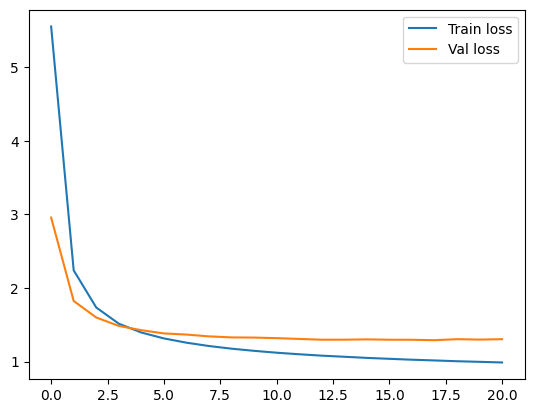

In [24]:
with open("./training.json", "w") as f:
    json.dump(training_hist.history, f)

plt.plot(training_hist.history["loss"], label="Train loss")
plt.plot(training_hist.history["val_loss"], label="Val loss")
plt.legend()
plt.show()

In [20]:
keras.utils.set_random_seed(RANDOM_SEED)


model.compile(
    loss = maskedCategoricalCrossentropy,
    optimizer = keras.optimizers.Adam(1e-5),
    metrics = ["categorical_accuracy"],
)

training_hist = model.fit(
    train_data,
    validation_data = val_data,
    epochs = 10,
    callbacks = [
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=3),
        keras.callbacks.ModelCheckpoint( 
            filepath = "./checkpoints/epoch{epoch:02d}-vloss{val_loss:.3f}.tuned.weights.h5",
            monitor = "val_loss",
            save_best_only = True,
            save_weights_only = True
        )
    ]
)

Epoch 1/10
1640/1640 [==============================] - 684s 406ms/step - loss: 0.9211 - categorical_accuracy: 0.4416 - val_loss: 1.2522 - val_categorical_accuracy: 0.4080
Epoch 2/10
1640/1640 [==============================] - 757s 461ms/step - loss: 0.8974 - categorical_accuracy: 0.4450 - val_loss: 1.2464 - val_categorical_accuracy: 0.4091
Epoch 3/10
1640/1640 [==============================] - 757s 462ms/step - loss: 0.8860 - categorical_accuracy: 0.4466 - val_loss: 1.2430 - val_categorical_accuracy: 0.4094
Epoch 4/10
1640/1640 [==============================] - 756s 461ms/step - loss: 0.8781 - categorical_accuracy: 0.4477 - val_loss: 1.2434 - val_categorical_accuracy: 0.4093
Epoch 5/10
1640/1640 [==============================] - 756s 461ms/step - loss: 0.8720 - categorical_accuracy: 0.4486 - val_loss: 1.2430 - val_categorical_accuracy: 0.4097
Epoch 6/10
1640/1640 [==============================] - 757s 462ms/step - loss: 0.8665 - categorical_accuracy: 0.4494 - val_loss: 1.2438 - v

## Evaluation

### Determine baseline

In [23]:
lcs_score = []
baseline_test_generator = DataGenerator(shuffled_data[220000:], batch_size=BATCH_SIZE, seed=RANDOM_SEED)

for gen_i in range(len(baseline_test_generator)):
    in_tokens, truth_tokens = baseline_test_generator[gen_i]

    str_x = detokenizer(in_tokens)
    str_y = detokenizer(truth_tokens)
    str_x = [ s[8:-6] for s in str_x ]
    str_y = [ s[8:-6] for s in str_y ]
    # print(str_x, str_y)
    for b in range(in_tokens.shape[0]):
        lcs_score.append(score(str_y[b], str_x[b]))


lcs_mean = np.mean(lcs_score)
lcs_std = np.std(lcs_score)
print(f"{lcs_mean} +/- {lcs_std}")
print("Target baseline:", lcs_mean + 3*lcs_std)

0.19210208987741956 +/- 0.05680775530181049
Target baseline: 0.36252535578285106


### Model evaluation

In [24]:
def inference(model, shuffled_tokens):
    """
        Computes the detokenized predictions on a batch of tokenized sentences.
        A mask indicating whether the sentence was correctly generated with the <end> token is also returned.
    """
    batch_size = shuffled_tokens.shape[0]
    pred_sents = [""] * batch_size
    autoregressive = np.array([[START_TOKEN] + [PAD_TOKEN] * (SEQ_MAX_LEN-1)] * batch_size)
    overflowing_mask = []

    for i in range(SEQ_MAX_LEN-1):
        out = model.predict_on_batch(( shuffled_tokens, autoregressive ))

        for b in range(batch_size):
            if len(pred_sents[b]) != 0: continue # Batch entry already generated

            pred_token = np.argmax(out[b, i, :])
            autoregressive[b, i+1] = pred_token

            if pred_token == END_TOKEN:
                pred_sents[b] = detokenizer([autoregressive[b]])[0]

        if all([ len(s) > 0 for s in pred_sents ]):
            break

    # Handle sentences without <end>
    for b in range(batch_size):
        if len(pred_sents[b]) == 0:
            pred_sents[b] = detokenizer([autoregressive[b]])[0] + " <end>" # Add <end> just for uniformity (will be removed later)
            overflowing_mask.append(True)
        else:
            overflowing_mask.append(False)

    return pred_sents, overflowing_mask

In [25]:
scores = []
overflowing_mask = []
test_generator = DataGenerator(shuffled_data[220000:], batch_size=BATCH_SIZE, seed=RANDOM_SEED)

tqdm_bar = tqdm(range(len(test_generator)))

for gen_i in tqdm_bar:
    in_tokens, truth_tokens = test_generator[gen_i]

    batch_size = truth_tokens.shape[0]
    truth_sents = [ detokenizer([truth_tokens[b]])[0] for b in range(batch_size) ]
    pred_sents, batch_overflowing_mask = inference(model, in_tokens)
    overflowing_mask += batch_overflowing_mask

    for b in range(batch_size):
        assert pred_sents[b][:8] == "<start> " and pred_sents[b][-6:] == " <end>"
        assert truth_sents[b][:8] == "<start> " and truth_sents[b][-6:] == " <end>"
        pred_sents[b] = pred_sents[b][8:-6]
        truth_sents[b] = truth_sents[b][8:-6]

        scores.append( score(truth_sents[b], pred_sents[b]) )

        if len(pred_sents[b].strip()) == 0:
            print(f"{truth_sents[b]} predicted as empty")
        # print(f"{scores[-1]} --- |{pred_sents[b]}| --- |{truth_sents[b]}|")

    tqdm_bar.set_postfix({ "avg_score": f"{np.mean(scores):.5f}" })

  0%|          | 0/165 [00:00<?, ?it/s]

100%|██████████| 165/165 [11:49<00:00,  4.30s/it, avg_score=0.54069]


Results evaluated on 21120 instances
Avg. LCS score: 0.5406939807


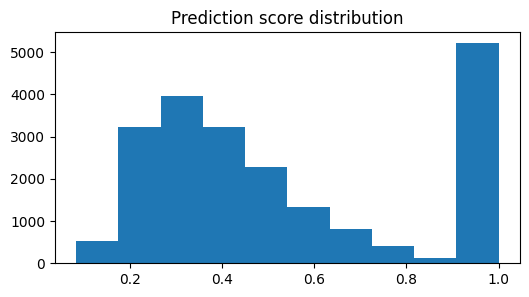

In [26]:
print(f"Results evaluated on {len(scores)} instances")
print(f"Avg. LCS score: {np.mean(scores):.10f}")

if any(overflowing_mask):
    scores_arr = np.array(scores)
    overflowing_mask_arr = np.array(overflowing_mask)
    scores_arr[overflowing_mask_arr] = 0

    print(f"Avg. LCS score (with {overflowing_mask.count(True)} overflowing instances zeroed): {np.mean(scores_arr):.10f}")


plt.figure(figsize=(6, 3))
plt.title("Prediction score distribution")
plt.hist(scores, bins=10)
plt.show()